# 1. Environment and project setup

### Section 1.1: Importing Libraries and GPU Configuration
This block imports necessary libraries for data processing (`os`, `numpy`, `librosa`) and model building using TensorFlow/Keras. It also verifies GPU availability to ensure the system leverages hardware acceleration.

In [43]:
# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import random

# Ensure TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
GPUs Available: []


### Section 1.2: Dataset Path Initialization
Defines paths for the ASVspoof2019 Logical Access dataset (training set, test set, and a test set with different distribution) along with their corresponding protocol files. This setup ensures structured access to audio and label data for preprocessing and model training.

In [44]:
# Dataset paths
DATASET_PATH = "/mnt/c/DF/LA/"
DATASET_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac")  # Path to training audio files
DATASET_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac")     # Path to validation audio files
DATASET_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac")   # Path to test audio files

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
LABELS_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
LABELS_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Print paths to verify correctness
print("Train Dataset Path:", DATASET_TRAIN)
print("Labels Train Path:", LABELS_TRAIN)

Train Dataset Path: /mnt/c/DF/LA/ASVspoof2019_LA_train/flac
Labels Train Path: /mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


### Section 1.3: Audio Preprocessing Configuration
Defines key parameters for audio preprocessing:
- **Sample rate:** 16 kHz to ensure uniformity.
- **Clip duration:** 5 seconds to standardize input length.
- **Mel bins:** 128 for Mel spectrogram generation.
The number of classes is set to 2 for binary classification (bonafide vs. spoof).

In [45]:
SAMPLE_RATE = 20000  # Sample rate of your audio files
DURATION = 1  # Duration of audio clips in seconds
N_FFT = 2048  # Window size for Short-Time Fourier Transform. 512 samples corresponds to ~32 ms at 16 kHz.
HOP_LENGTH = 512 # Step size for the STFT windows. A value of 256 (~50% overlap) ensures good temporal resolution.
MAX_LEN = 45000  # The target length of audio files in samples (2 seconds at 16 kHz = 32000 samples).
RANDOM_STATE = 2159081 # For reproducibility

random.seed(RANDOM_STATE)  # For reproducibility

# 2. Loading and balancing dataset labels
### Section 2.1: Loading Labels from Protocol Files
This block defines and uses a function to load labels from ASVspoof protocol files. Labels are mapped to filenames and splitted into two arrays for better reuse.

In [57]:
# Define a function to load labels and split filenames from the protocol file
def load_labels(file_path):
    bonafide_files = []
    spoof_files = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            if label == "bonafide":
                bonafide_files.append(filename)
            else:
                spoof_files.append(filename)
    return np.array(bonafide_files), np.array(spoof_files)

# Load training labels
train_bonafide_filenames, train_spoof_filenames = load_labels(LABELS_TRAIN)
test_bonafide_filenames, test_spoof_filenames = load_labels(LABELS_TEST)
test_unseen_bonafide_filenames, test_unseen_spoof_filenames = load_labels(LABELS_UNSEEN_TEST)

# Print some examples
print("Number of training bonafide samples:", len(train_bonafide_filenames))
print("Number of training spoof samples:", len(train_spoof_filenames))
print("Number of test bonafide samples:", len(test_bonafide_filenames))
print("Number of test spoof samples:", len(test_spoof_filenames))
print("Number of unseen test bonafide samples:", len(test_unseen_bonafide_filenames))
print("Number of unseen test spoof samples:", len(test_unseen_spoof_filenames))

Number of training bonafide samples: 2580
Number of training spoof samples: 22800
Number of test bonafide samples: 2548
Number of test spoof samples: 22296
Number of unseen test bonafide samples: 7355
Number of unseen test spoof samples: 63882


### Section 2.2: Reduce data for test speed

In [58]:
def shuffle_and_trim_list(input_list, n=10000):
    # List and shuffle
    random.shuffle(input_list)

    return input_list[:n]

# ATTENTION: Dataset limiting --------------------------------
train_bonafide_filenames = shuffle_and_trim_list(train_bonafide_filenames, n=2500)
train_spoof_filenames = shuffle_and_trim_list(train_spoof_filenames, n=2000)
test_bonafide_filenames = shuffle_and_trim_list(test_bonafide_filenames, n=2000)
test_spoof_filenames = shuffle_and_trim_list(test_spoof_filenames, n=2000)
test_unseen_bonafide_filenames = shuffle_and_trim_list(test_unseen_bonafide_filenames, n=2000)
test_unseen_spoof_filenames = shuffle_and_trim_list(test_unseen_spoof_filenames, n=2000)
# ATTENTION: Dataset limiting --------------------------------

# Print some examples
print("Number of training bonafide samples:", len(train_bonafide_filenames))
print("Number of training spoof samples:", len(train_spoof_filenames))
print("Number of test bonafide samples:", len(test_bonafide_filenames))
print("Number of test spoof samples:", len(test_spoof_filenames))
print("Number of unseen test bonafide samples:", len(test_unseen_bonafide_filenames))
print("Number of unseen test spoof samples:", len(test_unseen_spoof_filenames))

Number of training bonafide samples: 2500
Number of training spoof samples: 2000
Number of test bonafide samples: 2000
Number of test spoof samples: 2000
Number of unseen test bonafide samples: 2000
Number of unseen test spoof samples: 2000


# 3. Files loading and Preprocessing
### Section 3.1: Loading Dataset Files and STFT Conversion
- A function `load_dataset_files` is defined to:
  - Load audio files.
  - Convert them to STFT format using `librosa`.
- A progress bar (`tqdm`) is used to visualize file loading operations.
- The function processes and loads the training, validation, and testing datasets, ensuring the data is ready for model input.

In [59]:
import os
import librosa
import numpy as np
from tqdm import tqdm

# Load audio files with librosa, ensuring all are of the same length
def load_audio_files(dataset_path, file_list, sr=16000, max_len=32000):
    """
    Load audio files from a dataset path and ensure all are the same length with zero padding.
    
    Args:
        dataset_path (str): Path to the directory containing audio files.
        file_list (list): List of file names without extensions.
        sr (int): Sampling rate for librosa.load. Default is 16000.
        max_len (int): Target length for all audio signals (number of samples).
    
    Returns:
        np.array: Array of audio signals, all of the same length.
    """
    audio_data = []
    for filename in tqdm(file_list, desc="Loading audio files"):
        file_path = os.path.join(dataset_path, f"{filename}.flac")
        try:
            # Load the audio with the target sampling rate
            audio, _ = librosa.load(file_path, sr=sr, duration=max_len / sr)
            
            # Fix the length to max_len (zero padding or trimming as needed)
            audio = librosa.util.fix_length(audio, size=max_len)
            
            audio_data.append(audio)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return np.array(audio_data)

# Load the balanced dataset
audio_data_train_bonafide = load_audio_files(DATASET_TRAIN, train_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_train_spoof = load_audio_files(DATASET_TRAIN, train_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_test_bonafide = load_audio_files(DATASET_TEST, test_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_test_spoof = load_audio_files(DATASET_TEST, test_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_unseen_test_bonafide = load_audio_files(DATASET_UNSEEN_TEST, test_unseen_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
audio_data_unseen_test_spoof = load_audio_files(DATASET_UNSEEN_TEST, test_unseen_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)


Loading audio files: 100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:21<00:00, 91.81it/s]


### Section 3.2: Extract STFT features

In [60]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Function to extract Short-Time Fourier Transform (STFT) features from audio files
def compute_stft(audio_files, n_fft=2048, hop_length=512):
    stft_features = []  # Initialize a list to store STFT features for each audio file.
    
    for audio in tqdm(audio_files, desc="Extracting STFT features"):
        # Compute the Short-Time Fourier Transform (STFT) of the audio signal.
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        
        # Compute the magnitude spectrogram by taking the absolute value of the STFT result.
        spectrogram = np.abs(stft)
        
        # Append the magnitude spectrogram to the features list.
        stft_features.append(spectrogram)
    
    # Convert the list of spectrograms to a NumPy array and return it.
    return np.array(stft_features)

# Compute STFT for all samples
stft_data_train_bonafide = compute_stft(audio_data_train_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_train_spoof = compute_stft(audio_data_train_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_test_bonafide = compute_stft(audio_data_test_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_test_spoof = compute_stft(audio_data_test_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_unseen_test_bonafide = compute_stft(audio_data_unseen_test_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
stft_data_unseen_test_spoof = compute_stft(audio_data_unseen_test_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)

Extracting STFT features: 100%|████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 973.60it/s]


### Section 3.3: STFT data Visualization & Analysys

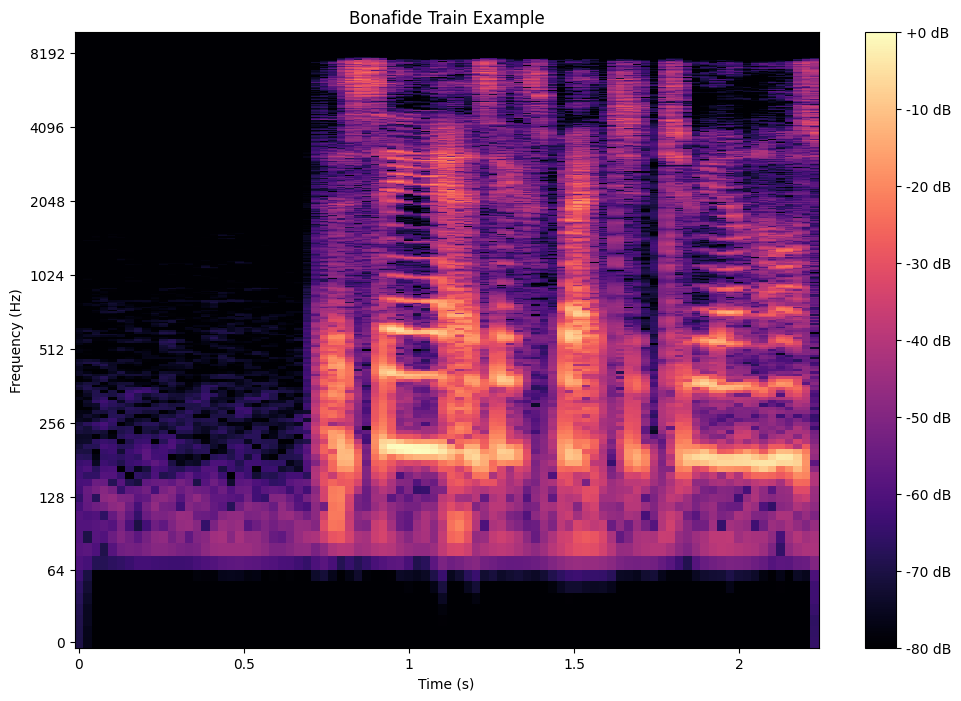

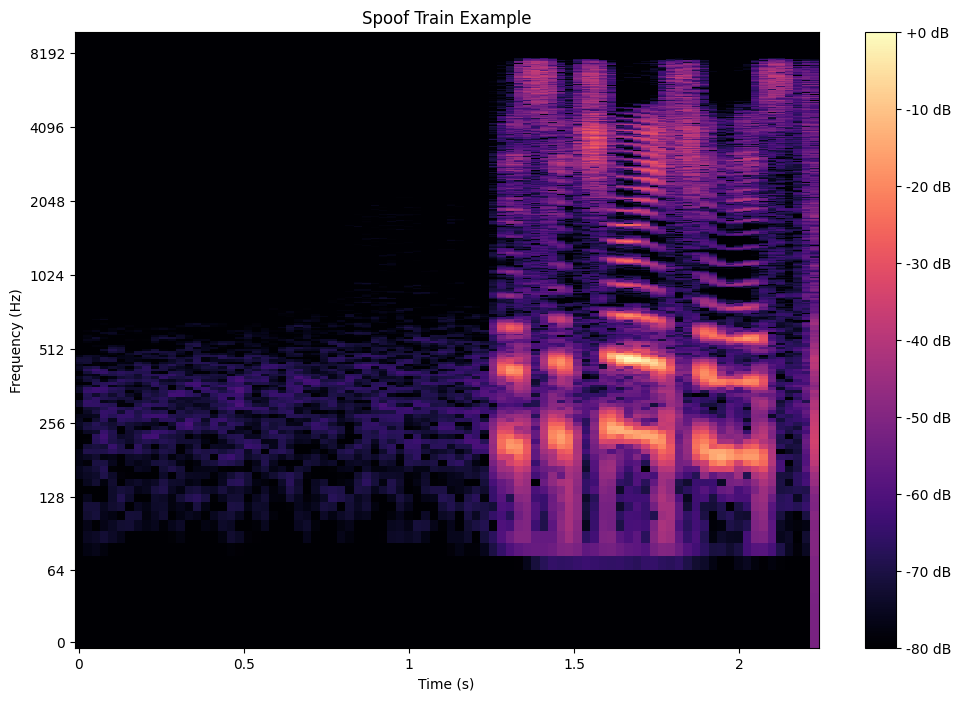

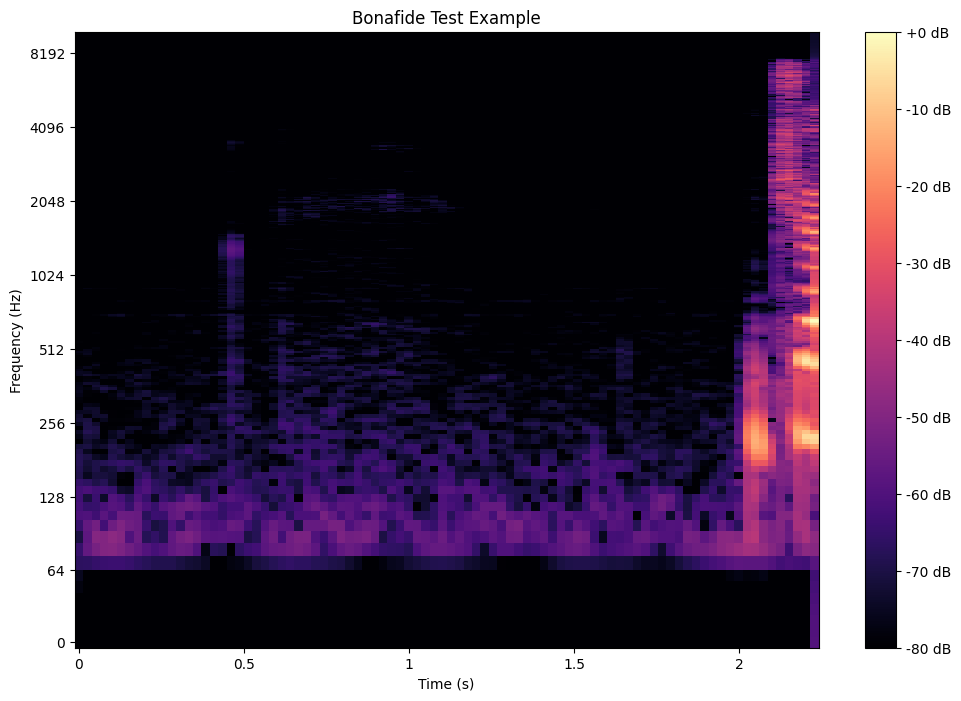

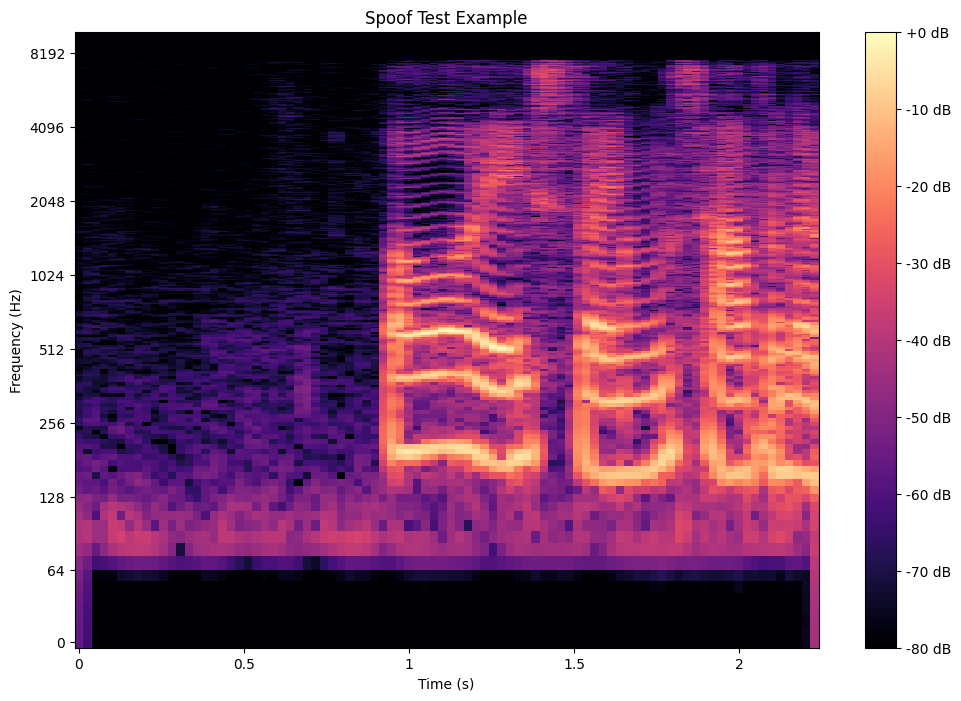

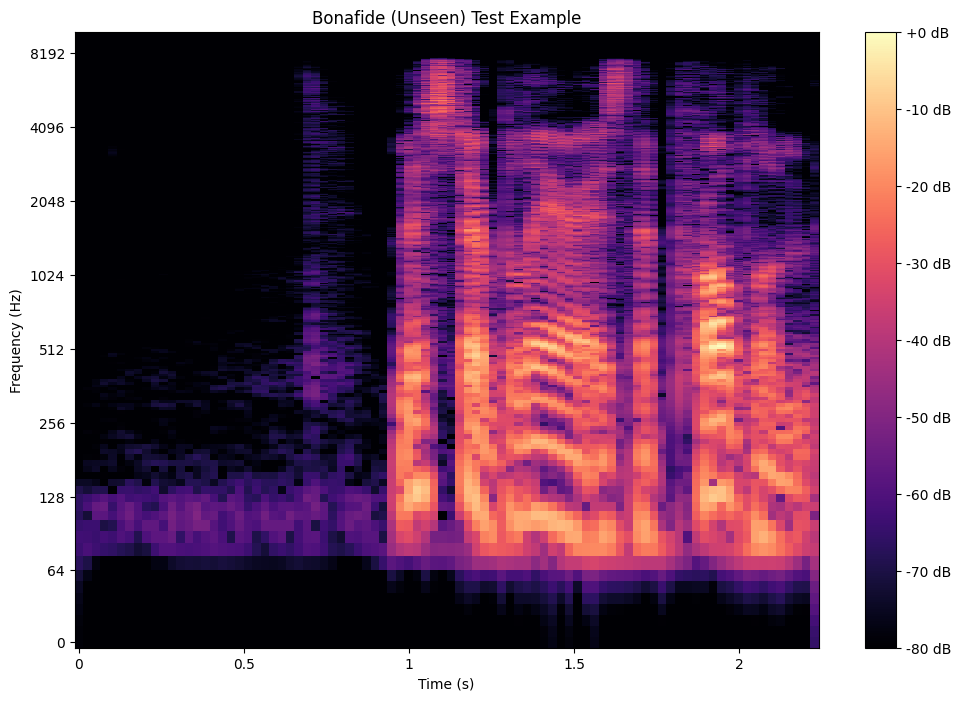

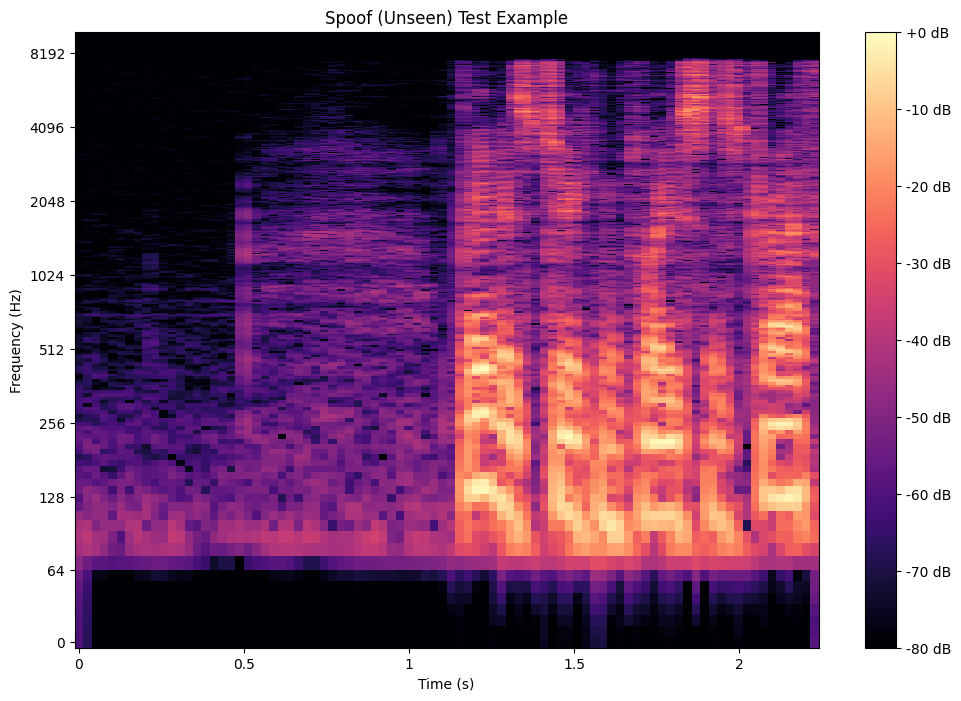

In [61]:
import random
import matplotlib.pyplot as plt

# Function to compute and visualize the spectrogram of an audio file
def plot_spectrogram(spectrogram, title, sr=16000, hop_length=512):
    # Set up the figure for plotting
    plt.figure(figsize=(12, 8))
    
    # Display the spectrogram, converting amplitude values to decibels (dB)
    librosa.display.specshow(
        librosa.amplitude_to_db(spectrogram, ref=np.max),  # Convert amplitude to dB scale
        sr=sr,  # Sampling rate of the audio signal
        hop_length=hop_length,  # Hop length used in the STFT
        x_axis='time',  # Display time on the x-axis
        y_axis='log'    # Use a logarithmic scale for the frequency axis
    )
    
    # Add a color bar to indicate the dB scale
    plt.colorbar(format='%+2.0f dB')
    
    # Add plot title and axis labels
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    
    # Display the plot
    plt.show()

# Generate a random integer between 0 and 100 (inclusive)
random_number = random.randint(0, 100)

# Plot some example
plot_spectrogram(stft_data_train_bonafide[random_number], "Bonafide Train Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_train_spoof[random_number], "Spoof Train Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_test_bonafide[random_number], "Bonafide Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_test_spoof[random_number], "Spoof Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_unseen_test_bonafide[random_number], "Bonafide (Unseen) Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_unseen_test_spoof[random_number], "Spoof (Unseen) Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)

# 4. Feature reduction: Autoencoder and Latent Space
### Section 4.1: Transpose the data to adapt it to autoencoder input

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler_fitted = 0

def preprocess_and_trasform_data(stft_data, string_data):
    print(f"Original {string_data} shape: {stft_data.shape}")
    stft_data = stft_data.transpose(0, 2, 1)
    print(f"Transposed {string_data} shape: {stft_data.shape}")
    if scaler_fitted == 0:
        stft_data = scaler.fit_transform(stft_data.reshape(-1, stft_data.shape[-1])).reshape(stft_data.shape)
    else:
        stft_data = scaler.transform(stft_data.reshape(-1, stft_data.shape[-1])).reshape(stft_data.shape)
    print(f"Scaled {string_data} shape: {stft_data.shape}\n\n")
    return stft_data


stft_data_train_bonafide = preprocess_and_trasform_data(stft_data_train_bonafide, "Train Bonafide")
stft_data_train_spoof = preprocess_and_trasform_data(stft_data_train_spoof, "Train Spoof")
stft_data_test_bonafide = preprocess_and_trasform_data(stft_data_test_bonafide, "Test Bonafide")
stft_data_test_spoof = preprocess_and_trasform_data(stft_data_test_spoof, "Test Spoof")
stft_data_unseen_test_bonafide = preprocess_and_trasform_data(stft_data_unseen_test_bonafide, "Test (Unseen) Bonafide")
stft_data_unseen_test_spoof = preprocess_and_trasform_data(stft_data_unseen_test_spoof, "Test (Unseen) Spoof")

Original Train Bonafide shape: (2500, 1025, 88)
Transposed Train Bonafide shape: (2500, 88, 1025)
Scaled Train Bonafide shape: (2500, 88, 1025)


Original Train Spoof shape: (2000, 1025, 88)
Transposed Train Spoof shape: (2000, 88, 1025)
Scaled Train Spoof shape: (2000, 88, 1025)


Original Test Bonafide shape: (2000, 1025, 88)
Transposed Test Bonafide shape: (2000, 88, 1025)
Scaled Test Bonafide shape: (2000, 88, 1025)


Original Test Spoof shape: (2000, 1025, 88)
Transposed Test Spoof shape: (2000, 88, 1025)
Scaled Test Spoof shape: (2000, 88, 1025)


Original Test (Unseen) Bonafide shape: (2000, 1025, 88)
Transposed Test (Unseen) Bonafide shape: (2000, 88, 1025)
Scaled Test (Unseen) Bonafide shape: (2000, 88, 1025)


Original Test (Unseen) Spoof shape: (2000, 1025, 88)
Transposed Test (Unseen) Spoof shape: (2000, 88, 1025)
Scaled Test (Unseen) Spoof shape: (2000, 88, 1025)




### Section 4.2: Autoencoder definition

In [77]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input dimensions
time_steps = 88  # Adjusted to be divisible by 4
n_stft = 1025    # Number of STFT coefficients
latent_dim = 96  # Dimension of the latent space

# Encoder
encoder_inputs = tf.keras.Input(shape=(time_steps, n_stft))  # Input layer with shape (time_steps, n_stft)
encoded = layers.LSTM(128, return_sequences=True)(encoder_inputs)  # First LSTM layer with 128 units, returning sequences
encoded = layers.LSTM(latent_dim, return_sequences=False)(encoded)  # Second LSTM layer reducing to latent_dim, without returning sequences

# Decoder
decoded = layers.RepeatVector(time_steps)(encoded)  # Repeat latent vector for each time step
decoded = layers.LSTM(128, return_sequences=True)(decoded)  # LSTM layer reconstructing intermediate sequences
decoded = layers.LSTM(n_stft, return_sequences=True)(decoded)  # Final LSTM layer reconstructing original dimensions

# Autoencoder
autoencoder_sftf = models.Model(encoder_inputs, decoded, name="Autoencoder")

# Encoder model for latent representation
latent_model_sftf = models.Model(encoder_inputs, encoded, name="Encoder")

# Compile the autoencoder
autoencoder_sftf.compile(optimizer='adam', loss='mse')

# Display model summaries
autoencoder_sftf.summary()
latent_model_sftf.summary()


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 88, 1025)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 88, 128)        │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_11 (RepeatVector) │ (None, 88, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 88, 128)        │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 88, 1025)       │     4,731,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,523,848 (21.07 MB)

 Trainable params: 5,523,848 (21.07 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 88, 1025)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 88, 128)        │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 96)             │        86,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,248 (2.58 MB)

 Trainable params: 677,248 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

### Section 4.3: Autoencoder training

In [78]:
# Data training
autoencoder_sftf.fit(
    stft_data_train_bonafide,
    stft_data_train_bonafide,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 560ms/step - loss: 5.8785e-04 - val_loss: 5.5866e-04
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 562ms/step - loss: 5.2835e-04 - val_loss: 5.2783e-04
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 575ms/step - loss: 5.2420e-04 - val_loss: 5.2230e-04
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 593ms/step - loss: 5.1129e-04 - val_loss: 5.0764e-04
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - loss: 4.9881e-04 - val_loss: 4.9872e-04


### Section 4.4: Rebuilt testset and plot reconstruction error

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step


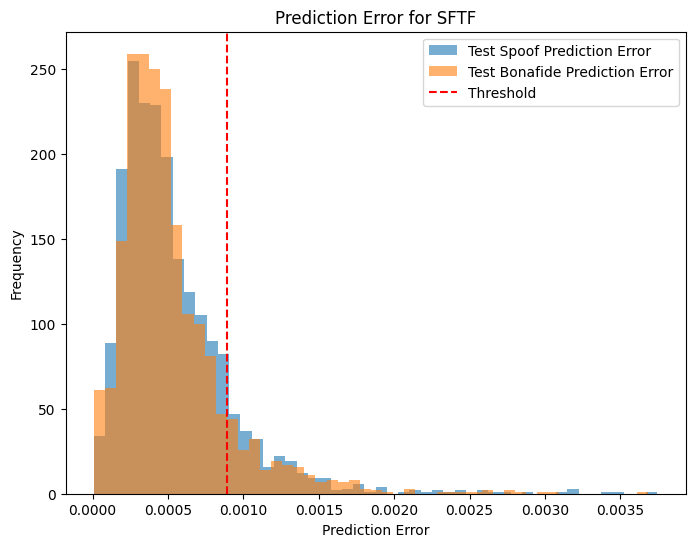

In [79]:
import matplotlib.pyplot as plt

# Use the autoencoder to reconstruct the test and spoof sample datasets
predicted_data_test_bonafide = autoencoder_sftf.predict(stft_data_test_bonafide)
predicted_data_test_spoof = autoencoder_sftf.predict(stft_data_test_spoof)

# Calculate Mean Squared Error (MSE) for reconstruction loss
test_bonafide_loss = np.mean(np.square(stft_data_test_bonafide - predicted_data_test_bonafide), axis=(1, 2))
test_spoof_loss = np.mean(np.square(stft_data_test_spoof - predicted_data_test_spoof), axis=(1, 2))

# Plot histogram of reconstruction errors
plt.figure(figsize=(8, 6))
plt.hist(test_spoof_loss, bins=50, alpha=0.6, label='Test Spoof Prediction Error')
plt.hist(test_bonafide_loss, bins=50, alpha=0.6, label='Test Bonafide Prediction Error')
plt.axvline(np.mean(test_bonafide_loss) + 1 * np.std(test_bonafide_loss), color='r', linestyle='--', label='Threshold')
plt.title("Prediction Error for SFTF")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Section 4.5: Extract and evaluate latent space for dimensionality reduction

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
(2500, 96)
(2000, 96)
(2000, 96)
Classification Report (bonafide sample First):
                 precision    recall  f1-score   support

   spoof sample       0.53      0.13      0.21      2000
bonafide sample       0.50      0.89      0.64      2000

       accuracy                           0.51      4000
      macro avg       0.52      0.51      0.42      4000
   weighted avg       0.52      0.51      0.42      4000

ROC-AUC Score: 0.51


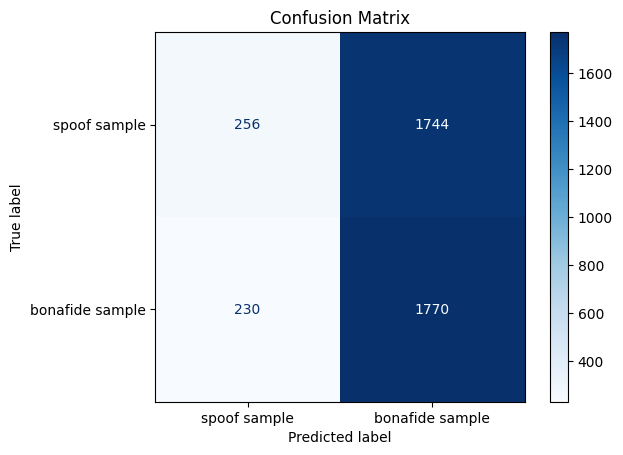

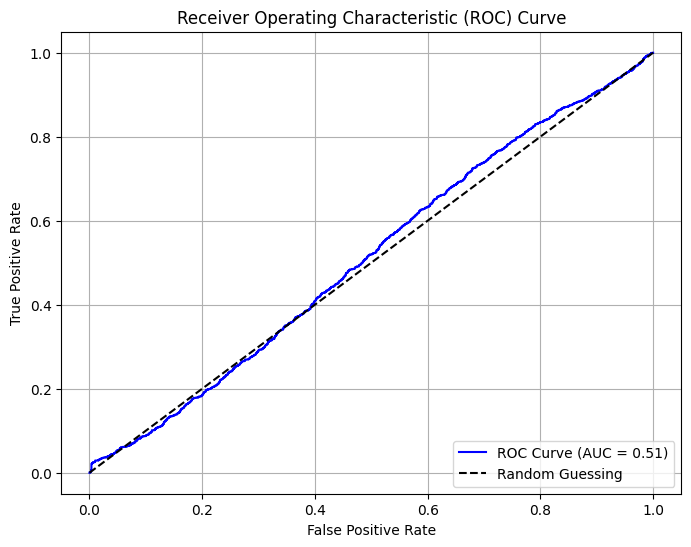

In [80]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict the latent space for the train bonafide, test bonafide and test spoof dataset
latent_stft_train_bonafide = latent_model_sftf.predict(stft_data_train_bonafide)
latent_stft_test_bonafide = latent_model_sftf.predict(stft_data_test_bonafide)
latent_stft_test_spoof = latent_model_sftf.predict(stft_data_test_spoof)

print(latent_stft_train_bonafide.shape)
print(latent_stft_test_bonafide.shape)
print(latent_stft_test_spoof.shape)

# Calculate the spoof sample detection threshold
threshold = np.mean(test_bonafide_loss) + 1 * np.std(test_bonafide_loss)  # Mean + 1 standard deviation of test_bonafide_loss

# Classify test and spoof sample samples based on the threshold
test_bonafide_predictions = (test_bonafide_loss < threshold).astype(int)  # 1 = bonafide sample, 0 = spoof sample
test_spoof_predictions = (test_spoof_loss < threshold).astype(int)  # 1 = bonafide sample, 0 = spoof sample

# Create true labels for evaluation
y_true_labels = np.concatenate([np.ones(len(test_bonafide_loss)), np.zeros(len(test_spoof_loss))])  # 1 = bonafide sample, 0 = spoof sample

# Combine predictions for test and spoof sample datasets
y_predicted_labels = np.concatenate([test_bonafide_predictions, test_spoof_predictions])

# Print classification report
print("Classification Report (bonafide sample First):")
print(classification_report(y_true_labels, y_predicted_labels, target_names=["spoof sample", "bonafide sample"]))

# Calculate ROC-AUC score
y_scores = np.concatenate([1 - test_bonafide_loss / threshold, 1 - test_spoof_loss / threshold])  # Normalized scores
roc_auc = roc_auc_score(y_true_labels, y_scores)  # Compute the ROC-AUC
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot the confusion matrix
cm = confusion_matrix(y_true_labels, y_predicted_labels)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof sample", "bonafide sample"])  # Display configuration
disp.plot(cmap="Blues")  # Plot with a blue colormap
plt.title("Confusion Matrix")
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_true_labels, y_scores)  # Compute false positive rate and true positive rate
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")  # Plot the ROC curve
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()  # Add grid for better visualization
plt.show()